# Synthetic Data Generation Using RAGAS - RAG Evaluation with LangSmith

In the following notebook we'll explore a use-case for RAGAS' synthetic testset generation workflow!


  1. Use RAGAS to Generate Synthetic Data
  2. Load them into a LangSmith Dataset
  3. Evaluate our RAG chain against the synthetic test data
  4. Make changes to our pipeline
  5. Evaluate the modified pipeline

SDG is a critical piece of the puzzle, especially for early iteration! Without it, it would not be nearly as easy to get high quality early signal for our application's performance.

Let's dive in!

## Task 1: Dependencies and API Keys

We'll need to install a number of API keys and dependencies, since we'll be leveraging a number of great technologies for this pipeline!

1. OpenAI's endpoints to handle the Synthetic Data Generation
2. OpenAI's Endpoints for our RAG pipeline and LangSmith evaluation
3. QDrant as our vectorstore
4. LangSmith for our evaluation coordinator!

Let's install and provide all the required information below!

## Dependencies and API Keys:

> NOTE: DO NOT RUN THESE CELLS IF YOU ARE RUNNING THIS NOTEBOOK LOCALLY

In [7]:
#!pip install -qU ragas==0.2.10

In [8]:
#!pip install -qU langchain-community==0.3.14 langchain-openai==0.2.14 unstructured==0.16.12 langgraph==0.2.61 langchain-qdrant==0.2.0

### NLTK Import

To prevent errors that may occur based on OS - we'll import NLTK and download the needed packages to ensure correct handling of data.

In [1]:
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Andrei\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Andrei\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [2]:
import os
import getpass

os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_API_KEY"] = getpass.getpass("LangChain API Key:")

We'll also want to set a project name to make things easier for ourselves.

In [3]:
from uuid import uuid4

os.environ["LANGCHAIN_PROJECT"] = f"PSI - SDG - {uuid4().hex[0:8]}"

OpenAI's API Key!

In [4]:
os.environ["OPENAI_API_KEY"] = getpass.getpass("OpenAI API Key:")

## Generating Synthetic Test Data

We wil be using Ragas to build out a set of synthetic test questions, references, and reference contexts. This is useful because it will allow us to find out how our system is performing.

> NOTE: Ragas is best suited for finding *directional* changes in your LLM-based systems. The absolute scores aren't comparable in a vacuum.

### Data Preparation

We'll prepare our data - which should hopefull be familiar at this point since it's our Loan Data use-case!

Next, let's load our data into a familiar LangChain format using the `DirectoryLoader`.

In [5]:
from langchain_community.document_loaders import DirectoryLoader
from langchain_community.document_loaders import PyMuPDFLoader


path = "bills/"
loader = DirectoryLoader(path, glob="*.pdf", loader_cls=PyMuPDFLoader)
docs = loader.load()

### Knowledge Graph Based Synthetic Generation

Ragas uses a knowledge graph based approach to create data. This is extremely useful as it allows us to create complex queries rather simply. The additional testset complexity allows us to evaluate larger problems more effectively, as systems tend to be very strong on simple evaluation tasks.

Let's start by defining our `generator_llm` (which will generate our questions, summaries, and more), and our `generator_embeddings` which will be useful in building our graph.

### Unrolled SDG

In [6]:
from ragas.llms import LangchainLLMWrapper
from ragas.embeddings import LangchainEmbeddingsWrapper
from langchain_openai import ChatOpenAI
from langchain_openai import OpenAIEmbeddings
generator_llm = LangchainLLMWrapper(ChatOpenAI(model="gpt-4.1-nano"))
generator_embeddings = LangchainEmbeddingsWrapper(OpenAIEmbeddings())

Next, we're going to instantiate our Knowledge Graph.

This graph will contain N number of nodes that have M number of relationships. These nodes and relationships (AKA "edges") will define our knowledge graph and be used later to construct relevant questions and responses.

In [7]:
from ragas.testset.graph import KnowledgeGraph

kg = KnowledgeGraph()
kg

KnowledgeGraph(nodes: 0, relationships: 0)

The first step we're going to take is to simply insert each of our full documents into the graph. This will provide a base that we can apply transformations to.

In [8]:
from ragas.testset.graph import Node, NodeType

### NOTICE: We're using a subset of the data for this example - this is to keep costs/time down.
for doc in docs[:20]:
    kg.nodes.append(
        Node(
            type=NodeType.DOCUMENT,
            properties={"page_content": doc.page_content, "document_metadata": doc.metadata}
        )
    )
kg

KnowledgeGraph(nodes: 20, relationships: 0)

Now, we'll apply the *default* transformations to our knowledge graph. This will take the nodes currently on the graph and transform them based on a set of [default transformations](https://docs.ragas.io/en/latest/references/transforms/#ragas.testset.transforms.default_transforms).

These default transformations are dependent on the corpus length, in our case:

- Producing Summaries -> produces summaries of the documents
- Extracting Headlines -> finding the overall headline for the document
- Theme Extractor -> extracts broad themes about the documents

It then uses cosine-similarity and heuristics between the embeddings of the above transformations to construct relationships between the nodes.

In [9]:
from ragas.testset.transforms import default_transforms, apply_transforms

transformer_llm = generator_llm
embedding_model = generator_embeddings

default_transforms = default_transforms(documents=docs, llm=transformer_llm, embedding_model=embedding_model)
apply_transforms(kg, default_transforms)
kg

Applying SummaryExtractor:   0%|          | 0/16 [00:00<?, ?it/s]

Applying CustomNodeFilter:   0%|          | 0/20 [00:00<?, ?it/s]

Node 03d5ff76-f978-4fb7-bb61-f39a13a25a4b does not have a summary. Skipping filtering.
Node a51fcdaa-dc6c-4791-91aa-426d74fb54c3 does not have a summary. Skipping filtering.
Node 565c68d1-9700-4f62-8528-c385aad78ad3 does not have a summary. Skipping filtering.
Node db4908bd-ed5d-4c35-bb3e-c6258c4b1a60 does not have a summary. Skipping filtering.


Applying [EmbeddingExtractor, ThemesExtractor, NERExtractor]:   0%|          | 0/56 [00:00<?, ?it/s]

Applying [CosineSimilarityBuilder, OverlapScoreBuilder]:   0%|          | 0/2 [00:00<?, ?it/s]

KnowledgeGraph(nodes: 20, relationships: 136)

We can save and load our knowledge graphs as follows.

In [10]:
kg.save("bills/ai_law.json")
bills_data_kg = KnowledgeGraph.load("bills/ai_law.json")
bills_data_kg

KnowledgeGraph(nodes: 20, relationships: 136)

Using our knowledge graph, we can construct a "test set generator" - which will allow us to create queries.

In [11]:
from ragas.testset import TestsetGenerator

generator = TestsetGenerator(llm=generator_llm, embedding_model=embedding_model, knowledge_graph=bills_data_kg)

However, we'd like to be able to define the kinds of queries we're generating - which is made simple by Ragas having pre-created a number of different "QuerySynthesizer"s.

Each of these Synthetsizers is going to tackle a separate kind of query which will be generated from a scenario and a persona.

In essence, Ragas will use an LLM to generate a persona of someone who would interact with the data - and then use a scenario to construct a question from that data and persona.

In [12]:
from ragas.testset.synthesizers import default_query_distribution, SingleHopSpecificQuerySynthesizer, MultiHopAbstractQuerySynthesizer, MultiHopSpecificQuerySynthesizer

query_distribution = [
        (SingleHopSpecificQuerySynthesizer(llm=generator_llm), 0.5),
        (MultiHopAbstractQuerySynthesizer(llm=generator_llm), 0.25),
        (MultiHopSpecificQuerySynthesizer(llm=generator_llm), 0.25),
]

<div style="background-color: #204B8E; color: white; padding: 10px; border-radius: 5px;">

#### ❓ Question #1:

What are the three types of query synthesizers doing? Describe each one in simple terms.

</div>


<div style="background-color: #204B8E; color: white; padding: 10px; border-radius: 5px;">

### Answer :

* **SingleHopSpecificQuerySynthesizer:**  
  Generates simple, direct questions that can be answered using information from a single node of the knowledge graph. These are straightforward, fact-based queries.

* **MultiHopAbstractQuerySynthesizer:**  
  Creates more complex questions that require combining information from multiple nodes in the knowledge graph, but in a more general or abstract way. These questions often require reasoning across several pieces of information.

* **MultiHopSpecificQuerySynthesizer:**  
  Produces detailed, multi-step questions that require connecting specific facts from different nodes in the knowledge graph. These queries are both specific and require reasoning over multiple steps or relationships.

</span>


Finally, we can use our `TestSetGenerator` to generate our testset!

In [13]:
testset = generator.generate(testset_size=10, query_distribution=query_distribution)
testset.to_pandas()

Generating personas:   0%|          | 0/3 [00:00<?, ?it/s]

Generating Scenarios:   0%|          | 0/3 [00:00<?, ?it/s]

Generating Samples:   0%|          | 0/11 [00:00<?, ?it/s]

,user_input,reference_contexts,reference,synthesizer_name
0,What role does the United Nations play in the ...,[TWENTIETH CONGRESS OF THE \nREPUBLIC OF THE P...,The United Nations emphasizes the need for coo...,single_hop_specifc_query_synthesizer
1,What opportunities does AI offer for the Phili...,[AI presents enormous opportunities for the Ph...,AI presents enormous opportunities for the Phi...,single_hop_specifc_query_synthesizer
2,What does the Philippine Constitution say abou...,[TWENTIETH CONGRESS OF THE \nREPUBLIC OF THE P...,The context does not specify the exact provisi...,single_hop_specifc_query_synthesizer
3,How does the context define Artificial General...,"[1 \na) Promote innovation, technological adva...",The context states that the Act shall regulate...,single_hop_specifc_query_synthesizer
4,How does Artificial General Intelligence (AGI)...,[1\n2\n3\n4\n5\n6\n7\n8 \n9\n10\n11\n12\n13\n1...,Artificial General Intelligence (AGI) refers t...,single_hop_specifc_query_synthesizer
5,How do impact assessment and notification requ...,[<1-hop>\n\n1 \nd) Take full responsibility fo...,The impact assessment and notification require...,multi_hop_abstract_query_synthesizer
6,how do ethcal standrds and transparecy in AI d...,[<1-hop>\n\n1 \ndevelopment priorities. These ...,The context discusses penalties for developing...,multi_hop_abstract_query_synthesizer
7,How do the registration and licensing requirem...,[<1-hop>\n\n1 \ndevelopment priorities. These ...,The context indicates that the development and...,multi_hop_abstract_query_synthesizer
8,How does the Philippines' Artificial Intellige...,"[<1-hop>\n\n1 \na) Promote innovation, technol...",The Philippines' Artificial Intelligence Regul...,multi_hop_specific_query_synthesizer
9,"How does the Philippines' AI policy framework,...","[<1-hop>\n\n1 \na) Promote innovation, technol...",The Philippines' AI policy framework promotes ...,multi_hop_specific_query_synthesizer


### Abstracted SDG

The above method is the full process - but we can shortcut that using the provided abstractions!

This will generate our knowledge graph under the hood, and will - from there - generate our personas and scenarios to construct our queries.



In [14]:
from ragas.testset import TestsetGenerator

generator = TestsetGenerator(llm=generator_llm, embedding_model=generator_embeddings)
dataset = generator.generate_with_langchain_docs(docs[:20], testset_size=10)

Applying SummaryExtractor:   0%|          | 0/16 [00:00<?, ?it/s]

Applying CustomNodeFilter:   0%|          | 0/20 [00:00<?, ?it/s]

Node f783c4c5-506a-4052-a83e-05ab54984326 does not have a summary. Skipping filtering.
Node 89ae74b0-dde7-480a-8074-04f4eba272dc does not have a summary. Skipping filtering.
Node 3d51c8fc-01ac-4806-a92c-a7db8db6470f does not have a summary. Skipping filtering.
Node 4cd06099-faa1-4089-9a73-782675b46418 does not have a summary. Skipping filtering.


Applying [EmbeddingExtractor, ThemesExtractor, NERExtractor]:   0%|          | 0/56 [00:00<?, ?it/s]

Applying [CosineSimilarityBuilder, OverlapScoreBuilder]:   0%|          | 0/2 [00:00<?, ?it/s]

Generating personas:   0%|          | 0/3 [00:00<?, ?it/s]

Generating Scenarios:   0%|          | 0/3 [00:00<?, ?it/s]

Generating Samples:   0%|          | 0/12 [00:00<?, ?it/s]

In [15]:
dataset.to_pandas()

,user_input,reference_contexts,reference,synthesizer_name
0,What United Nations do about AI regulation?,[TWENTIETH CONGRESS OF THE \nREPUBLIC OF THE P...,The context mentions that the United Nations S...,single_hop_specifc_query_synthesizer
1,What are the concerns associated with the rise...,[AI presents enormous opportunities for the Ph...,The concerns associated with the rise of Artif...,single_hop_specifc_query_synthesizer
2,Who is PIA S. CAYETANO in the context of the P...,[TWENTIETH CONGRESS OF THE \nREPUBLIC OF THE P...,PIA S. CAYETANO is the senator who introduced ...,single_hop_specifc_query_synthesizer
3,Philippines?,"[1 \na) Promote innovation, technological adva...",The context discusses the regulation of AI dev...,single_hop_specifc_query_synthesizer
4,How do the regulations address the use of AI t...,[<1-hop>\n\n1 \niii) Mandatory compliance trai...,The regulations in the Philippines explicitly ...,multi_hop_abstract_query_synthesizer
5,How do penalties for non-disclosure of AI-gene...,[<1-hop>\n\n1 \niii) Mandatory compliance trai...,The context specifies that failure to disclose...,multi_hop_abstract_query_synthesizer
6,H0w do the NAIC's juristiction over AI and the...,[<1-hop>\n\n1 \nSec. 6. Jurisdiction of the NA...,The NAIC has the exclusive juristiction over a...,multi_hop_abstract_query_synthesizer
7,How do the regulations outlined in Sec. 15 and...,[<1-hop>\n\n1 \nSec. 15. AI Ethics Review Boar...,The regulations in Sec. 15 establish the AI Et...,multi_hop_abstract_query_synthesizer
8,How does the DOST relate to the NAIC's jurisdi...,[<1-hop>\n\n1 \nSec. 6. Jurisdiction of the NA...,The DOST is responsible for the composition an...,multi_hop_specific_query_synthesizer
9,how does the artificial intelligence regulatio...,"[<1-hop>\n\n1 \na) Promote innovation, technol...",the artificial intelligence regulation act (ai...,multi_hop_specific_query_synthesizer


We'll need to provide our LangSmith API key, and set tracing to "true".

## Task 4: LangSmith Dataset

Now we can move on to creating a dataset for LangSmith!

First, we'll need to create a dataset on LangSmith using the `Client`!

We'll name our Dataset to make it easy to work with later.

In [43]:
from langsmith import Client

client = Client()

dataset_name = "Philippines AI Bills"

langsmith_dataset = client.create_dataset(
    dataset_name=dataset_name,
    description="Philippines AI Bills"
)

We'll iterate through the RAGAS created dataframe - and add each example to our created dataset!

> NOTE: We need to conform the outputs to the expected format - which in this case is: `question` and `answer`.

In [44]:
for data_row in dataset.to_pandas().iterrows():
  client.create_example(
      inputs={
          "question": data_row[1]["user_input"]
      },
      outputs={
          "answer": data_row[1]["reference"]
      },
      metadata={
          "context": data_row[1]["reference_contexts"]
      },
      dataset_id=langsmith_dataset.id
  )

## Basic RAG Chain

Time for some RAG!


In [45]:
rag_documents = docs

To keep things simple, we'll just use LangChain's recursive character text splitter!


In [46]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size = 500,
    chunk_overlap = 50
)

rag_documents = text_splitter.split_documents(rag_documents)

We'll create our vectorstore using OpenAI's [`text-embedding-3-small`](https://platform.openai.com/docs/guides/embeddings/embedding-models) embedding model.

In [47]:
from langchain_openai import OpenAIEmbeddings

embeddings = OpenAIEmbeddings(model="text-embedding-3-small")

As usual, we will power our RAG application with Qdrant!

In [48]:
from langchain_community.vectorstores import Qdrant

vectorstore = Qdrant.from_documents(
    documents=rag_documents,
    embedding=embeddings,
    location=":memory:",
    collection_name="AI Bills RAG"
)

In [49]:
retriever = vectorstore.as_retriever(search_kwargs={"k": 10})

To get the "A" in RAG, we'll provide a prompt.

In [50]:
from langchain.prompts import ChatPromptTemplate

RAG_PROMPT = """\
Given a provided context and question, you must answer the question based only on context.

If you cannot answer the question based on the context - you must say "I don't know".

Context: {context}
Question: {question}
"""

rag_prompt = ChatPromptTemplate.from_template(RAG_PROMPT)

For our LLM, we will be using TogetherAI's endpoints as well!

We're going to be using Meta Llama 3.1 70B Instruct Turbo - a powerful model which should get us powerful results!

In [51]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4.1-mini")

Finally, we can set-up our RAG LCEL chain!

In [52]:
from operator import itemgetter
from langchain_core.runnables import RunnablePassthrough, RunnableParallel
from langchain.schema import StrOutputParser

rag_chain = (
    {"context": itemgetter("question") | retriever, "question": itemgetter("question")}
    | rag_prompt | llm | StrOutputParser()
)

In [53]:
rag_chain.invoke({"question" : "How much is the penalty for spreading disinformation?"})

'The penalty for using AI to create or disseminate disinformation is:\n\n- A fine of One Million Pesos (Php 1,000,000) to Five Million Pesos (Php 5,000,000),  \n- or imprisonment of three (3) years to ten (10) years,  \n- or both, at the discretion of the court.  \n\nAdditional penalties may apply if the acts are committed during election periods, public emergencies, or in violation of constitutional rights.'

## LangSmith Evaluation Set-up

We'll use OpenAI's GPT-4.1 as our evaluation LLM for our base Evaluators.

In [54]:
eval_llm = ChatOpenAI(model="gpt-4.1")

We'll be using a number of evaluators - from LangSmith provided evaluators, to a few custom evaluators!

In [55]:
from langsmith.evaluation import LangChainStringEvaluator, evaluate

qa_evaluator = LangChainStringEvaluator("qa", config={"llm" : eval_llm})

labeled_helpfulness_evaluator = LangChainStringEvaluator(
    "labeled_criteria",
    config={
        "criteria": {
            "helpfulness": (
                "Is this submission helpful to the user,"
                " taking into account the correct reference answer?"
            )
        },
        "llm" : eval_llm
    },
    prepare_data=lambda run, example: {
        "prediction": run.outputs["output"],
        "reference": example.outputs["answer"],
        "input": example.inputs["question"],
    }
)

empathy_evaluator = LangChainStringEvaluator(
    "criteria",
    config={
        "criteria": {
            "empathy": "Is this response empathetic? Does it make the user feel like they are being heard?",
        },
        "llm" : eval_llm
    }
)

<div style="background-color: #204B8E; color: white; padding: 10px; border-radius: 5px;">

#### 🏗️ Question #2:

Highlight what each evaluator is evaluating.

- `qa_evaluator`:
- `labeled_helpfulness_evaluator`:

</div>

<div style="background-color: #204B8E; color: white; padding: 10px; border-radius: 5px;">

### Answer:

* **qa_evaluator**
Evaluates whether the generated answer is correct and matches the reference answer for the question. It checks the factual accuracy and completeness of the response.
* **labeled_helpfulness_evaluator**
Assesses how helpful the answer is to the user, considering the reference answer. It focuses on the usefulness and practical value of the response for the user's needs.

</div>

## LangSmith Evaluation

In [56]:
evaluate(
    rag_chain.invoke,
    data=dataset_name,
    evaluators=[
        qa_evaluator,
        labeled_helpfulness_evaluator,
        empathy_evaluator
    ],
    metadata={"revision_id": "default_chain_init"},
)

View the evaluation results for experiment: 'perfect-sponge-42' at:
https://smith.langchain.com/o/4423eed6-51ef-4779-87fd-836990774900/datasets/e478c11c-5002-4015-9b59-5629604cd564/compare?selectedSessions=4a862ea9-72c7-4ff0-9600-b0e0a8a998f5




0it [00:00, ?it/s]

,inputs.question,outputs.output,error,reference.answer,feedback.correctness,feedback.helpfulness,feedback.empathy,execution_time,example_id,id
0,DOST NAIC AI regulation how it work with DOST ...,"Based on the provided context, the National AI...",None,The NAIC has exclusive jurisdiction over AI ma...,1,1,0,8.433667,f3b8ed41-14d3-4013-94e9-53d2078c7b21,552c01ff-1b8d-47e3-bcb0-ea2341c12d6e
1,H0w do Sec. 10 and Sec. 16 of the AI Act relat...,"Based on the provided context, Sec. 10 and Sec...",None,Sec. 10 of the AI Act outlines the development...,0,0,0,13.098076,35810278-5eef-456b-badd-83b977694b5f,36565c00-1cef-4f1d-9cdc-dcca7b541b42
2,how does the artificial intelligence regulatio...,The Artificial Intelligence Regulation Act reg...,None,the artificial intelligence regulation act (ai...,1,1,0,5.344911,a02f13ee-2bb5-4c42-ba87-c962c85364ce,3c59aff2-2101-4476-92e9-9db99b0c9547
3,How does the DOST relate to the NAIC's jurisdi...,Based on the provided context:\n\nThe Departme...,None,The DOST is responsible for the composition an...,1,1,0,4.506280,9ec035c2-29f0-4666-8f95-10795b86adac,112ecf13-55ae-457f-8666-09ed111fa7b7
4,How do the regulations outlined in Sec. 15 and...,"Based on the provided context, the regulations...",None,The regulations in Sec. 15 establish the AI Et...,1,0,0,9.866708,a81a7d9c-8ee6-4bca-baaa-a74506cf3ebb,b0569c3b-54ee-4534-b25a-6702d0bcb243
5,H0w do the NAIC's juristiction over AI and the...,Based on the context provided:\n\nThe NAIC (Na...,None,The NAIC has the exclusive juristiction over a...,1,1,0,6.662019,769ae92f-95d4-4919-ad10-fbaa7f7c1f3a,45039197-b186-47e1-97ca-cf00bc6bc529
6,How do penalties for non-disclosure of AI-gene...,"Based on the provided context, the overall AI ...",None,The context specifies that failure to disclose...,1,0,0,4.228289,2f386c96-8ff6-4219-9c7e-9b2ab97da0d0,5f1904fd-94a7-49c6-8f20-a58643dabdbe
7,How do the regulations address the use of AI t...,"Based on the provided context, the regulations...",None,The regulations in the Philippines explicitly ...,1,0,0,7.068922,6a870d42-7a5b-41ca-81ca-2b49dc902842,8a99610f-5c5e-4996-973d-44edfa0cf601
8,Philippines?,The context indicates that the documents perta...,None,The context discusses the regulation of AI dev...,1,1,0,3.981545,07e0666a-452c-476d-af06-4eb1fa166146,08528c99-06f9-44c1-aa39-6e346e9d45b9
9,Who is PIA S. CAYETANO in the context of the P...,PIA S. CAYETANO is a Senator who introduced th...,None,PIA S. CAYETANO is the senator who introduced ...,1,1,0,1.671664,b8578e15-bef7-4c87-a39a-18f6ce838ad4,691d791b-54c9-429c-9a89-cbd71fb725c6


## Dope-ifying Our Application

We'll be making a few changes to our RAG chain to increase its performance on our SDG evaluation test dataset!

- Include a "dope" prompt augmentation
- Use larger chunks
- Improve the retriever model to: `text-embedding-3-large`

Let's see how this changes our evaluation!

In [30]:
EMPATHY_RAG_PROMPT = """\
Given a provided context and question, you must answer the question based only on context.

If you cannot answer the question based on the context - you must say "I don't know".

You must answer the question using empathy and kindness, and make sure the user feels heard.

Context: {context}
Question: {question}
"""

empathy_rag_prompt = ChatPromptTemplate.from_template(EMPATHY_RAG_PROMPT)

In [31]:
rag_documents = docs

In [32]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size = 1000,
    chunk_overlap = 50
)

rag_documents = text_splitter.split_documents(rag_documents)

<div style="background-color: #204B8E; color: white; padding: 10px; border-radius: 5px;">

### ❓Question #2:

Why would modifying our chunk size modify the performance of our application?

</div>

<div style="background-color: #204B8E; color: white; padding: 10px; border-radius: 5px;">

### Answer:
Changing the chunk size affects how much context is available to the retrieval and generation steps. Larger chunks provide more context per retrieved document, which can help answer complex questions but may introduce irrelevant information. On the other hand, smaller chunks make retrieval more focused and precise, but may miss important context if the answer spans multiple chunks.

</div>

In [33]:
from langchain_openai import OpenAIEmbeddings

embeddings = OpenAIEmbeddings(model="text-embedding-3-large")

<div style="background-color: #204B8E; color: white; padding: 10px; border-radius: 5px;">

#### ❓Question #3:

Why would modifying our embedding model modify the performance of our application?

</div>

<div style="background-color: #204B8E; color: white; padding: 10px; border-radius: 5px;">

### Answer :

The embedding model determines how text is converted into vectors for similarity search. Better embedding models capture semantic meaning more accurately, improving the retrieval of relevant documents and thus the quality of answers. Weaker or less specialized models may miss important context or retrieve less relevant chunks, leading to poorer performance.

</div>

In [34]:
vectorstore = Qdrant.from_documents(
    documents=rag_documents,
    embedding=embeddings,
    location=":memory:",
    collection_name="AI Bills RAG 2"
)

In [35]:
retriever = vectorstore.as_retriever()

Setting up our new and improved DOPE RAG CHAIN.

In [36]:
empathy_rag_chain = (
    {"context": itemgetter("question") | retriever, "question": itemgetter("question")}
    | empathy_rag_prompt | llm | StrOutputParser()
)

Let's test it on the same output that we saw before.

In [37]:
empathy_rag_chain.invoke({"question" : "Why is the Philippines AI Bill important?"})

"Thank you for your question—it's clear that understanding the importance of such legislation is very meaningful, especially as AI rapidly changes our world.\n\nBased on the context provided, the Philippines AI Bill is important because it aims to balance encouraging technological innovation with ensuring that AI systems are safe, ethical, transparent, and subject to meaningful human oversight. This is crucial given the transformative impact of AI on industries, governance, and society. The bill provides a general framework to promote responsible and lawful AI development, supporting Filipino ingenuity, addressing national development challenges, and safeguarding the rights and welfare of every citizen.\n\nMoreover, the bill recognizes the State’s responsibility to prevent AI from being used to commit crimes, abuse rights, or cause harm, whether intentional or accidental, while still promoting technological progress. This thoughtful approach seeks to ensure that AI contributes positive

Finally, we can evaluate the new chain on the same test set!

In [57]:
evaluate(
    empathy_rag_chain.invoke,
    data=dataset_name,
    evaluators=[
        qa_evaluator,
        labeled_helpfulness_evaluator,
        empathy_evaluator
    ],
    metadata={"revision_id": "empathy_rag_chain"},
)

View the evaluation results for experiment: 'reflecting-trick-50' at:
https://smith.langchain.com/o/4423eed6-51ef-4779-87fd-836990774900/datasets/e478c11c-5002-4015-9b59-5629604cd564/compare?selectedSessions=312e04a9-8a9e-45cf-91e6-fc6932a53be0




0it [00:00, ?it/s]

,inputs.question,outputs.output,error,reference.answer,feedback.correctness,feedback.helpfulness,feedback.empathy,execution_time,example_id,id
0,DOST NAIC AI regulation how it work with DOST ...,Thank you for your thoughtful question about h...,None,The NAIC has exclusive jurisdiction over AI ma...,1,1,1,6.123214,f3b8ed41-14d3-4013-94e9-53d2078c7b21,03bf9bbb-ee78-4c88-9e02-e1dd09b6113b
1,H0w do Sec. 10 and Sec. 16 of the AI Act relat...,Thank you for your thoughtful question. I unde...,None,Sec. 10 of the AI Act outlines the development...,0,0,1,7.682592,35810278-5eef-456b-badd-83b977694b5f,b864b8ee-9cf2-4af1-8aaf-ea7f882e866b
2,how does the artificial intelligence regulatio...,Thank you for your thoughtful question. Based ...,None,the artificial intelligence regulation act (ai...,1,1,1,5.214712,a02f13ee-2bb5-4c42-ba87-c962c85364ce,28ab6f7e-0b8e-4057-9566-7a8187d3ecdd
3,How does the DOST relate to the NAIC's jurisdi...,Thank you for your thoughtful question. Based ...,None,The DOST is responsible for the composition an...,1,1,1,7.542644,9ec035c2-29f0-4666-8f95-10795b86adac,341dae7c-6a0d-4545-abb3-d106f332aa7c
4,How do the regulations outlined in Sec. 15 and...,Thank you for your thoughtful question. It’s c...,None,The regulations in Sec. 15 establish the AI Et...,1,0,1,10.839385,a81a7d9c-8ee6-4bca-baaa-a74506cf3ebb,a8aa7b3f-7196-45cf-97d4-82c217fca3a5
5,H0w do the NAIC's juristiction over AI and the...,Thank you for your thoughtful question about h...,None,The NAIC has the exclusive juristiction over a...,1,1,1,6.088145,769ae92f-95d4-4919-ad10-fbaa7f7c1f3a,fecbb92e-1f2a-4c6a-8f78-0f6e3440eaf0
6,How do penalties for non-disclosure of AI-gene...,Thank you for your thoughtful question. Based ...,None,The context specifies that failure to disclose...,1,1,1,8.129715,2f386c96-8ff6-4219-9c7e-9b2ab97da0d0,14a32bb8-865a-4f77-847f-62ab7bdae2d8
7,How do the regulations address the use of AI t...,Thank you for your thoughtful question. It’s c...,None,The regulations in the Philippines explicitly ...,1,1,1,7.090636,6a870d42-7a5b-41ca-81ca-2b49dc902842,6eca5aad-5191-4f24-99a0-3a4260550222
8,Philippines?,Thank you for your question. Based on the cont...,None,The context discusses the regulation of AI dev...,1,1,1,4.298904,07e0666a-452c-476d-af06-4eb1fa166146,12eedb4f-4e1b-4482-82ae-d31d782cc2ef
9,Who is PIA S. CAYETANO in the context of the P...,Thank you for your question. Based on the cont...,None,PIA S. CAYETANO is the senator who introduced ...,1,1,1,4.591908,b8578e15-bef7-4c87-a39a-18f6ce838ad4,b6ecc402-8dcb-46ec-a2d8-b93eef01331d


<div style="background-color: #204B8E; color: white; padding: 10px; border-radius: 5px;">

#### 🏗️ Question #4:

Explain why you believe certain metrics changed in certain ways, and provide a screenshot of the difference between the two chains.

</div>

<div style="background-color: #204B8E; color: white; padding: 10px; border-radius: 5px;">

### Answer:

The metrics changed between the two chains because we made several improvements to the RAG pipeline. By explicitly instructing the model to be empathetic, the responses became more user-focused and considerate, which improved the empathy and helpfulness scores.

*Screenshot of the difference between the two chains:*
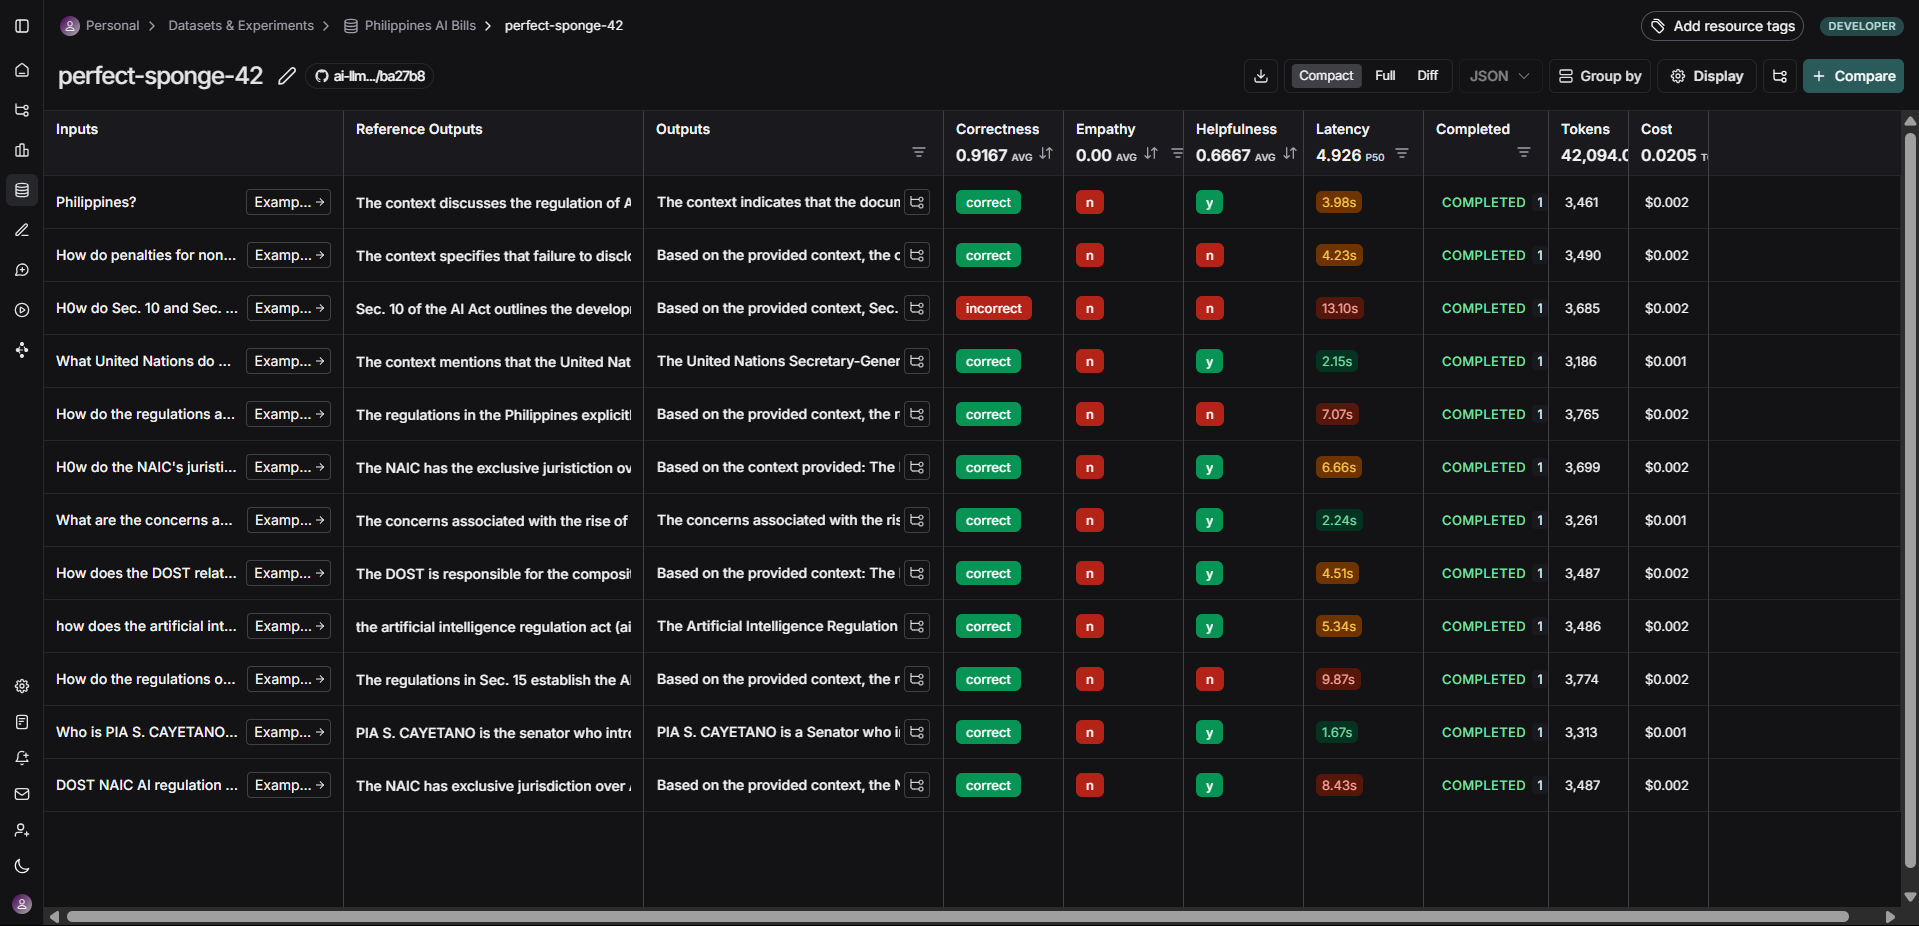
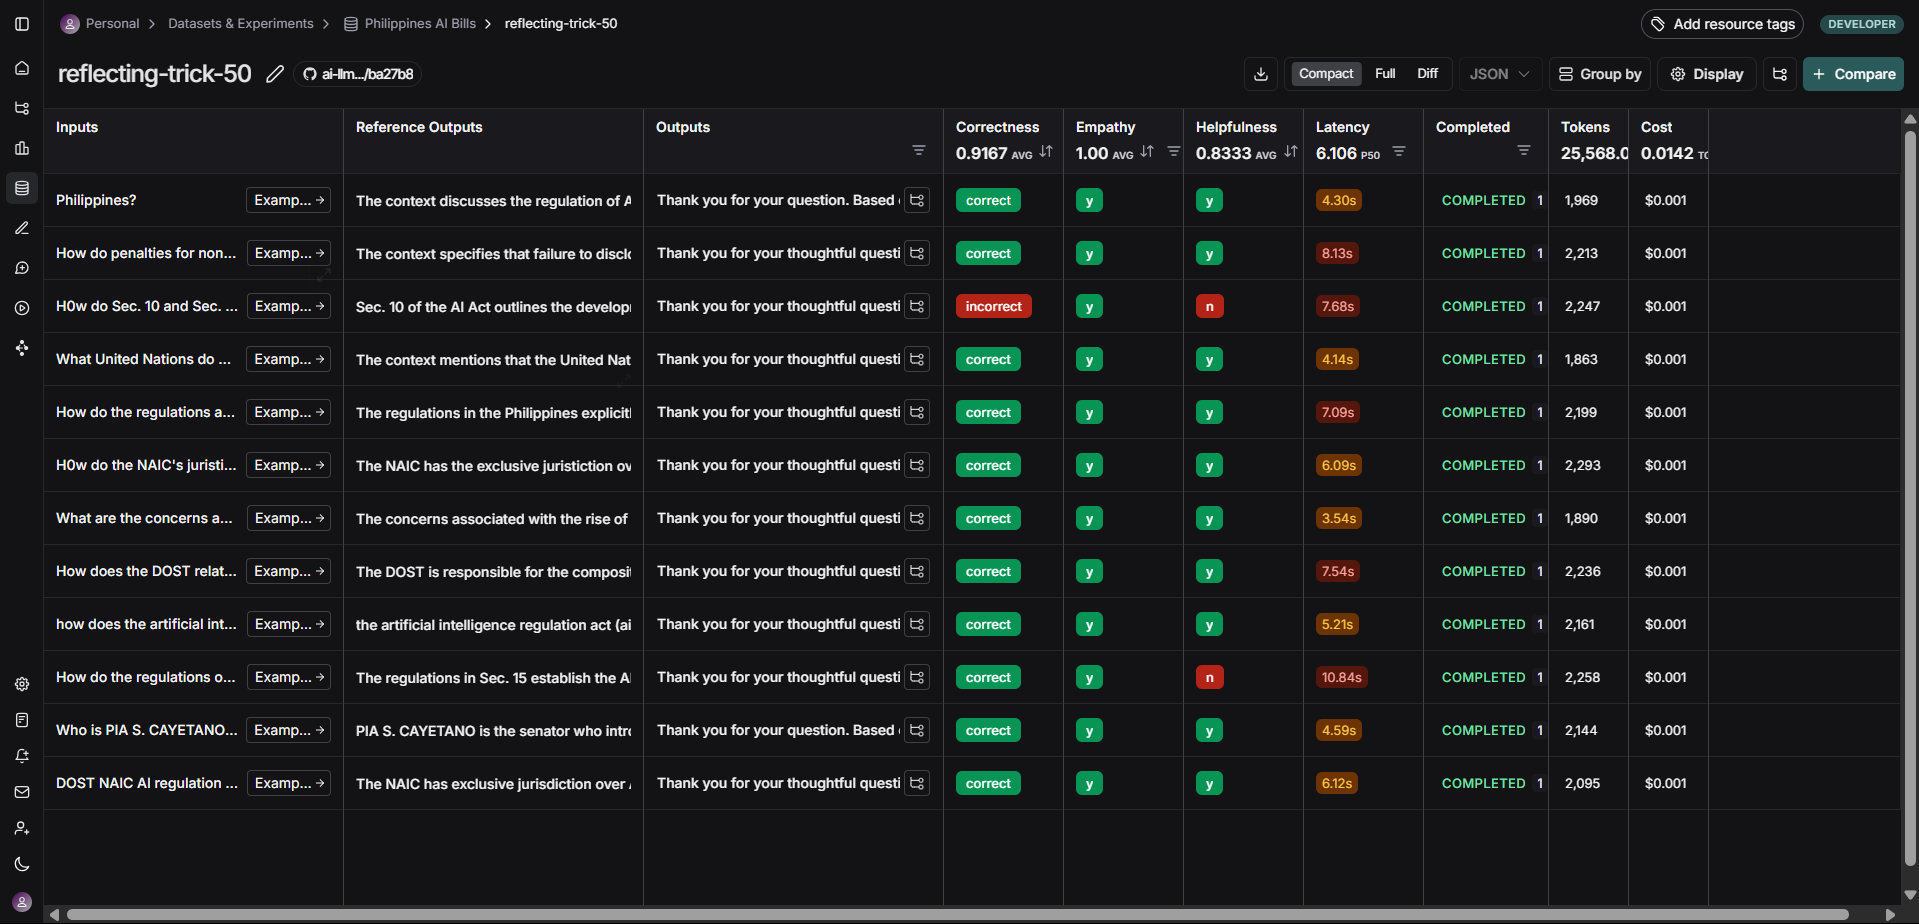

</div>